In [1]:
%matplotlib inline


Link Prediction using Graph Neural Networks
===========================================

In the :doc:`introduction <1_introduction>`, you have already learned
the basic workflow of using GNNs for node classification,
i.e. predicting the category of a node in a graph. This tutorial will
teach you how to train a GNN for link prediction, i.e. predicting the
existence of an edge between two arbitrary nodes in a graph.

By the end of this tutorial you will be able to

-  Build a GNN-based link prediction model.
-  Train and evaluate the model on a small DGL-provided dataset.

(Time estimate: 28 minutes)


In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Using backend: pytorch


Overview of Link Prediction with GNN
------------------------------------

Many applications such as social recommendation, item recommendation,
knowledge graph completion, etc., can be formulated as link prediction,
which predicts whether an edge exists between two particular nodes. This
tutorial shows an example of predicting whether a citation relationship,
either citing or being cited, between two papers exists in a citation
network.

This tutorial formulates the link prediction problem as a binary classification
problem as follows:

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training
   set and a test set.
-  Evaluate the model with any binary classification metric such as Area
   Under Curve (AUC).

<div class="alert alert-info"><h4>Note</h4><p>The practice comes from
   `SEAL <https://papers.nips.cc/paper/2018/file/53f0d7c537d99b3824f0f99d62ea2428-Paper.pdf>`__,
   although the model here does not use their idea of node labeling.</p></div>

In some domains such as large-scale recommender systems or information
retrieval, you may favor metrics that emphasize good performance of
top-K predictions. In these cases you may want to consider other metrics
such as mean average precision, and use other negative sampling methods,
which are beyond the scope of this tutorial.

Loading graph and features
--------------------------

Following the :doc:`introduction <1_introduction>`, this tutorial
first loads the Cora dataset.




In [2]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Prepare training and testing sets
---------------------------------

This tutorial randomly picks 10% of the edges for positive examples in
the test set, and leave the rest for the training set. It then samples
the same number of edges for negative examples in both sets.




In [3]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [15]:
eids.shape

(10556,)

In [19]:
u_list=u.tolist()
v_list=v.tolist()
u_list = list(map(int, u_list))
v_list = list(map(int, v_list))

In [5]:
import networkx as nx
import math
import itertools
import numpy as np

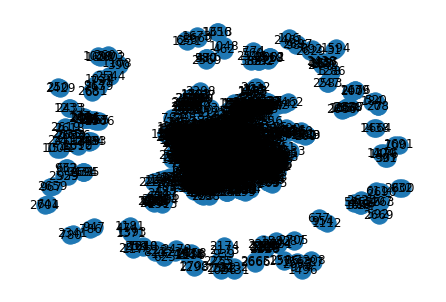

In [6]:
G = nx.Graph()
edgeList = [(i,j) for i,j in zip(u_list,v_list)]
G.add_edges_from(edgeList)
nx.draw(G, with_labels=True)

When training, you will need to remove the edges in the test set from
the original graph. You can do this via ``dgl.remove_edges``.

<div class="alert alert-info"><h4>Note</h4><p>``dgl.remove_edges`` works by creating a subgraph from the
   original graph, resulting in a copy and therefore could be slow for
   large graphs. If so, you could save the training and test graph to
   disk, as you would do for preprocessing.</p></div>




In [7]:
train_g = dgl.remove_edges(g, eids[:test_size])

Define a GraphSAGE model
------------------------

This tutorial builds a model consisting of two
`GraphSAGE <https://arxiv.org/abs/1706.02216>`__ layers, each computes
new node representations by averaging neighbor information. DGL provides
``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.




In [8]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

The model then predicts the probability of existence of an edge by
computing a score between the representations of both incident nodes
with a function (e.g. an MLP or a dot product), which you will see in
the next section.

\begin{align}\hat{y}_{u\sim v} = f(h_u, h_v)\end{align}




Positive graph, negative graph, and ``apply_edges``
---------------------------------------------------

In previous tutorials you have learned how to compute node
representations with a GNN. However, link prediction requires you to
compute representation of *pairs of nodes*.

DGL recommends you to treat the pairs of nodes as another graph, since
you can describe a pair of nodes with an edge. In link prediction, you
will have a *positive graph* consisting of all the positive examples as
edges, and a *negative graph* consisting of all the negative examples.
The *positive graph* and the *negative graph* will contain the same set
of nodes as the original graph.  This makes it easier to pass node
features among multiple graphs for computation.  As you will see later,
you can directly feed the node representations computed on the entire
graph to the positive and the negative graphs for computing pair-wise
scores.

The following code constructs the positive graph and the negative graph
for the training set and the test set respectively.




In [9]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

The benefit of treating the pairs of nodes as a graph is that you can
use the ``DGLGraph.apply_edges`` method, which conveniently computes new
edge features based on the incident nodes’ features and the original
edge features (if applicable).

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.




In [10]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

You can also write your own function if it is complex.
For instance, the following module produces a scalar score on each edge
by concatenating the incident nodes’ features and passing it to an MLP.




In [11]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

<div class="alert alert-info"><h4>Note</h4><p>The builtin functions are optimized for both speed and memory.
   We recommend using builtin functions whenever possible.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>If you have read the :doc:`message passing
   tutorial <3_message_passing>`, you will notice that the
   argument ``apply_edges`` takes has exactly the same form as a message
   function in ``update_all``.</p></div>




Training loop
-------------

After you defined the node representation computation and the edge score
computation, you can go ahead and define the overall model, loss
function, and evaluation metric.

The loss function is simply binary cross entropy loss.

\begin{align}\mathcal{L} = -\sum_{u\sim v\in \mathcal{D}}\left( y_{u\sim v}\log(\hat{y}_{u\sim v}) + (1-y_{u\sim v})\log(1-\hat{y}_{u\sim v})) \right)\end{align}

The evaluation metric in this tutorial is AUC.




In [12]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

The training loop goes as follows:

<div class="alert alert-info"><h4>Note</h4><p>This tutorial does not include evaluation on a validation
   set. In practice you should save and evaluate the best model based on
   performance on the validation set.</p></div>




In [13]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail credits: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

In epoch 0, loss: 0.6930944919586182
In epoch 5, loss: 0.6665489077568054
In epoch 10, loss: 0.5776367783546448
In epoch 15, loss: 0.5238140225410461
In epoch 20, loss: 0.4885309040546417
In epoch 25, loss: 0.4611351490020752
In epoch 30, loss: 0.4412820339202881
In epoch 35, loss: 0.41982391476631165
In epoch 40, loss: 0.3983992338180542
In epoch 45, loss: 0.3781243562698364
In epoch 50, loss: 0.35773298144340515
In epoch 55, loss: 0.3373328745365143
In epoch 60, loss: 0.3159000277519226
In epoch 65, loss: 0.29377463459968567
In epoch 70, loss: 0.2717411518096924
In epoch 75, loss: 0.2504790723323822
In epoch 80, loss: 0.2293386310338974
In epoch 85, loss: 0.2087334841489792
In epoch 90, loss: 0.1883375346660614
In epoch 95, loss: 0.1681683212518692
AUC 0.8634478111453021


In [24]:
train_pos_g

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})

In [29]:
train_neg_g

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})

In [28]:
h[1]

tensor([-0.0168, -0.2964,  0.9669, -0.9282,  0.1340,  0.3003, -1.2117,  0.3974,
        -0.5936, -0.7244,  0.3566, -0.0524,  0.6817,  0.4255,  0.2710,  0.2856],
       grad_fn=<SelectBackward>)